### 1. Perspective Transform function

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [9]:
img = cv2.imread(r'C:\Users\mokht\Desktop\Sudoku_Solver_OpenCV-ImageProcessing_course_project\test image\sudoku_test1.jpg')
output_size = (450, 450)

In [10]:
def perspectiveTransform(img, output_size):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to binarize the image(returns threshhold value and threshold img)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) #(src, thresh_value, max_val, threshhold_type)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # cv2.drawContours(img, contours, -1, (0, 255, 0), 2) #src, contours, -1:draw all contours, color, thickness
    # plt.imshow(img2)

    # Find the largest contour (the Sudoku board)
    largest_contour = max(contours, key=cv2.contourArea)

    # Perimeter of the largest contour found in the image
    peri = cv2.arcLength(largest_contour, True)
    '''
    largest_contour: is the contour whose perimeter will be calculated.
    closed: specifies whether the contour is closed (True) or open (False).
    '''

    # Get the corners of the Sudoku board
    approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)
    # print(approx)
    # cv2.drawContours(img, approx, -1, (0, 255, 0), 10) #src, contours, -1:draw all contours, color, thickness
    # plt.imshow(img2)

    # Reorder the corners in a clockwise direction starting from the top-left corner
    ordered_corners = np.zeros_like(approx)
    sum_coords = approx.sum(axis=2)
    ordered_corners[0] = approx[np.argmin(sum_coords)]
    ordered_corners[2] = approx[np.argmax(sum_coords)]
    diff_coords = np.diff(approx, axis=2)
    ordered_corners[1] = approx[np.argmin(diff_coords)]
    ordered_corners[3] = approx[np.argmax(diff_coords)]

    # Reshape the ordered corners to (4, 2) shape
    ordered_corners = np.float32(ordered_corners.reshape((4, 2)))

    # Define the destination points for perspective transformation
    dest_points = np.float32([[0, 0], [output_size[0], 0], [output_size[0], output_size[1]], [0, output_size[1]]])
    Matrix = cv2.getPerspectiveTransform(ordered_corners, dest_points)

    # Apply the perspective transformation to the original image
    output = cv2.warpPerspective(img, Matrix, output_size)
    
    return output

#### Testing the perspective function

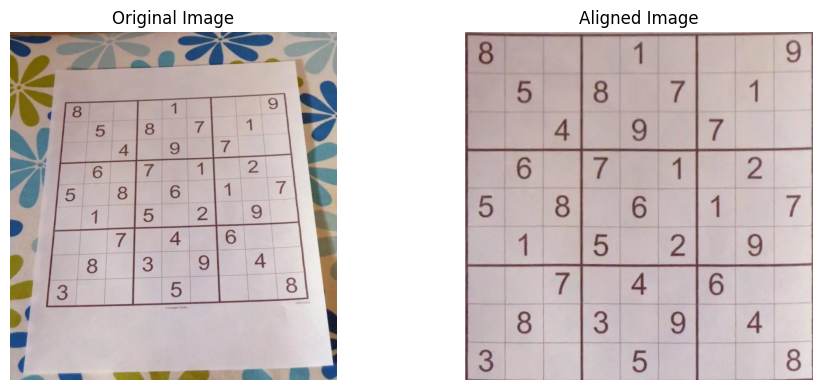

In [12]:
output = perspectiveTransform(img, output_size)

# Display the original image and the aligned image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image')
plt.axis('off')

plt.tight_layout()
plt.show()

#### Dividing the output image to 81 image

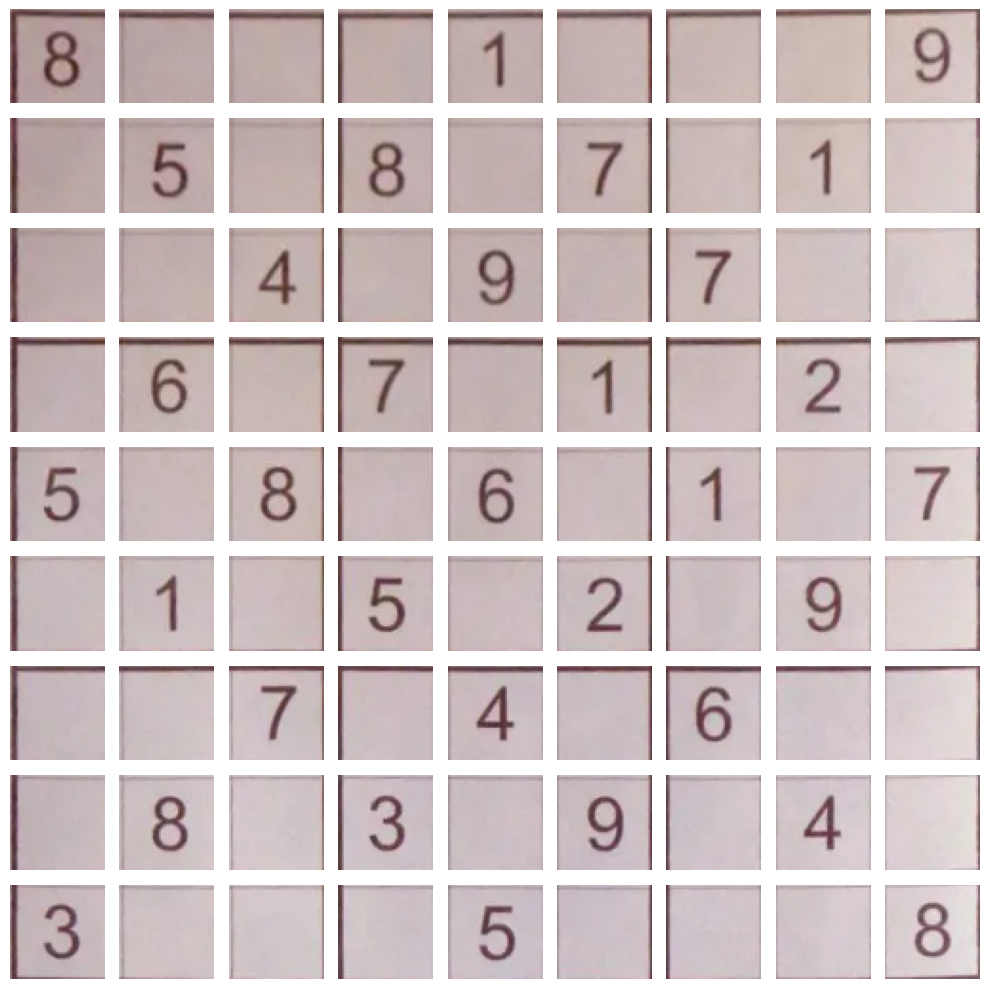

In [20]:
grid_size = 9
cell_size = output_size[0] // grid_size
cells = []

for i in range(grid_size):
    row = []
    for j in range(grid_size):
        cell = output[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
        row.append(cell)
    cells.append(row)
    
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        ax = axes[i, j]
        ax.imshow(cv2.cvtColor(cells[i][j], cv2.COLOR_BGR2RGB))
        ax.axis('off')

plt.tight_layout()
plt.show()

### Preprocess the cells and load the model

In [22]:
def preprocess_cell(cell):
    # Resize to 28x28
    cell = cv2.resize(cell, (28, 28))

    cell = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)

    cell = 255 - cell
    
    # Normalize pixel values
    cell = cell / 255.0
    
    # Expand dimensions for batch and channel
    cell = torch.tensor(cell).float().unsqueeze(0).unsqueeze(0)
    return cell

In [27]:
# Define the path to the saved model
model_path = 'C:\\Users\\mokht\\Desktop\\Sudoku_Solver_OpenCV-ImageProcessing_course_project\\model\\mnist_model.pth'

# Load the model
model = torch.load(model_path)

ModuleNotFoundError: No module named 'torch'

In [28]:
# List to store the predicted numbers
sudoku_numbers = []

# Iterate through the cells and make predictions
for row in cells:
    row_numbers = []
    for cell in row:
        preprocessed_cell = preprocess_cell(cell).to(device)
        with torch.no_grad():
            output = model(preprocessed_cell)
            _, predicted = torch.max(output.data, 1)
            row_numbers.append(predicted.item())
    sudoku_numbers.append(row_numbers)

# Print the predicted Sudoku grid
for row in sudoku_numbers:
    print(row)

NameError: name 'torch' is not defined